### Summary
- Neural Network model used: Multilayer Perceptron
- 34 features extracted
- Accuracy: average 96% on unseen test data with 5-fold cross validation
- Parameters used: ~1000

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from glob import glob
from timeit import default_timer as timer
import sys
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneGridSearchCV

from keras.utils import np_utils,to_categorical
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
np.set_printoptions(threshold=100) # 'sys.maxsize' for max

In [2]:
# modified from Sean's extractDataset.py

import sys
import os
import csv
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox, Button, RadioButtons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

from sklearn import preprocessing

# Definitions
BASEPATH = os.getcwd()
DANCEMOVENAMES = ("dab","elbowkick","gun","hair","listen","pointhigh","sidepump","wipetable")
IS_RETURN_DATAFRAME = True

#Changeable Parameters
NUMBER_OF_AFTER_SAMPLES = 3 #Number of samples to include in dance move after end detected
NUMBER_OF_BEFORE_SAMPLES = 5 #Number of samples to include in dance move before start detected
MINIMUM_MOVE_TIME = 25 #Minimum number of samples to be considered a move. Set this too low and you will get garbage dance samples

IS_PAD = True
PAD_NUM =20

USE_MAX_SAMPLES = True
MAX_SAMPLES = 100
USETEMP = True
USEACCEL= True
TEMPORALDATAAUGNUM = 5
NUMRANDOMSHIFTSACCEL = 5
Z_RAND_MAX = 0.05


class rawDataset():
    def __init__(self, device, movename, timestamp, dataset):
        self.device = device
        self.movename = movename
        self.timestamp = timestamp
        self.dataset = dataset
    def plot(self):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.dataset['activation_List']))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("Device " + str(self.device) + "\nActivation" )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )


        ax1, = accel.plot(index, self.dataset['a_xList'], label = "X")
        ax2, = accel.plot(index, self.dataset['a_yList'], label = "Y")
        ax3, = accel.plot(index, self.dataset['a_zList'], label = "Z")

        ax4, = gyro.plot(index, self.dataset['g_xList'], label = "X")
        ax5, = gyro.plot(index, self.dataset['g_yList'], label = "Y")
        ax6, = gyro.plot(index, self.dataset['g_zList'], label = "Z")

        ax7, = activation.plot(index, self.dataset['activation_List'], label = "R")
        
        displaylen = len(self.dataset['activation_List'])

        activation.set_xlim(xmin = 0 , xmax = displaylen )
        activation.set_ylim(ymin = 0.2 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = displaylen )
        accel.set_ylim(ymin = -2 , ymax = 2 )

        gyro.set_xlim(xmin = 0 , xmax = displaylen )
        gyro.set_ylim(ymin = -250 , ymax = 250 )
        
        plt.show()

    
        plt.clf()


class dancemove():
    def __init__(self, device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List ):
        self.device = device
        self.movename = movename
        self.timestamp = timestamp

        self.a_xList = a_xList
        self.a_yList = a_yList
        self.a_zList = a_zList

        self.g_xList = g_xList
        self.g_yList = g_yList
        self.g_zList = g_zList
        
        self.activation_List = activation_List

    def toDict(self):
        d = dict()
        d['movename'] = self.movename
        d['a_xList'] = self.a_xList
        d['a_yList'] = self.a_yList
        d['a_zList'] = self.a_zList
        d['g_xList'] = self.g_xList
        d['g_yList'] = self.g_yList
        d['g_zList'] = self.g_zList
        d['activation_List'] = self.activation_List
        return d

    def writeThisFile(self,moveid):
        fname = "{}_{}_{}_{}".format(self.device, self.movename, self.timestamp, str(moveid))
        f = os.path.join(BASEPATH,PROCESSEDFOLDER,fname ) 
        if not os.path.exists(os.path.dirname(f)):
            try:
                os.makedirs(os.path.dirname(f))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
        with open(f, 'w', newline='') as csvfile:
            row = [
                    'a_xList',
                    'a_yList',
                    'a_zList',
                    'g_xList',
                    'g_yList',
                    'g_zList',
                    'activation_List'
                ]
            csvWriter = csv.writer(csvfile, delimiter=',')
            csvWriter.writerow(row)
            for idx in range(len(self.a_xList)):
                row = [
                    self.a_xList[idx],
                    self.a_yList[idx],
                    self.a_zList[idx],
                    self.g_xList[idx],
                    self.g_yList[idx],
                    self.g_zList[idx],
                    self.activation_List[idx]
                ] 
                csvWriter.writerow(row)

    def plotNorm(self, show =True):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.activation_List))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("{} {} {}".format(self.device, self.movename, self.timestamp) )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )
        # print( self.a_xList)

        d = self.getDataAsNumpyArray( norm = True)
        ax1, = accel.plot(index, d[0], label = "X")
        ax2, = accel.plot(index, d[1], label = "Y")
        ax3, = accel.plot(index, d[2], label = "Z")

        ax4, = gyro.plot(index, d[3], label = "X")
        ax5, = gyro.plot(index, d[4], label = "Y")
        ax6, = gyro.plot(index, d[5], label = "Z")

        ax7, = activation.plot(index, self.activation_List, label = "R")
        

        activation.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        activation.set_ylim(ymin = 0 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        accel.set_ylim(ymin = 0 , ymax = 1.1 )

        gyro.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        gyro.set_ylim(ymin = 0 , ymax = 1.1 )

        if show:
            plt.show(block = True)
            plt.clf()

    def plot(self, show =True):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.activation_List))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("{} {} {}".format(self.device, self.movename, self.timestamp) )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )
        # print( self.a_xList)

        ax1, = accel.plot(index, self.a_xList, label = "X")
        ax2, = accel.plot(index, self.a_yList, label = "Y")
        ax3, = accel.plot(index, self.a_zList, label = "Z")

        ax4, = gyro.plot(index, self.g_xList, label = "X")
        ax5, = gyro.plot(index, self.g_yList, label = "Y")
        ax6, = gyro.plot(index, self.g_zList, label = "Z")

        ax7, = activation.plot(index, self.activation_List, label = "R")
        

        activation.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        activation.set_ylim(ymin = 0.2 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        accel.set_ylim(ymin = -2 , ymax = 2 )

        gyro.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        gyro.set_ylim(ymin = -250 , ymax = 250 )

        if show:
            plt.show(block = True)
            plt.clf()

    def print_Data(self):
        print(self.activation_List)

    def get_label(self):
        return self.movename

    def get_data(self):
        return [
            self.a_xList,
            self.a_yList,
            self.a_zList,
            self.g_xList,
            self.g_yList,
            self.g_zList,
            self.activation_List
        ] 

    def get_data_len(self):
        mydata = self.get_data()
        assert all(len(x)==len(mydata[0]) for x in mydata)
        return len(mydata[0])

    
    
    def getDataAsNumpyArray(self, norm = True):
            x = np.array(self.a_xList)
            y = np.array(self.a_yList)
            z = np.array(self.a_zList)
            x2 = np.array(self.g_xList)
            y2 = np.array(self.g_yList)
            z2 = np.array(self.g_zList)
            a = np.array(self.activation_List)

            if norm:
                NormLimit = 1
                x = (x+2)/4 * NormLimit
                y = (y+2)/4 * NormLimit
                z = (z+2)/4 * NormLimit

                x2 = (x2+250)/ (250 * 2) * NormLimit
                y2 = (y2+250)/ (250 * 2) * NormLimit
                z2 = (z2+250)/ (250 * 2) * NormLimit

                x = np.clip(x,0,NormLimit)
                y = np.clip(y,0,NormLimit)
                z = np.clip(z,0,NormLimit)

                x2 = np.clip(x2,0,NormLimit)
                y2 = np.clip(y2,0,NormLimit)
                z2 = np.clip(z2,0,NormLimit)

            
            f = [x,y,z,x2,y2,z2]
            return np.array(f)


def listFiles(savepath):
    filepath = os.path.join(BASEPATH, savepath)
    return os.listdir(filepath)

def extractFileMetadata(fname):
    device, movename, timestamp = fname.split("_")
    return (device, movename, timestamp)

def readRawDataset(fname, savepath):
    filepath = os.path.join(BASEPATH, savepath, fname)

    dataset = {
        'a_xList': [],
        'a_yList': [],
        'a_zList': [],
        'g_xList': [],
        'g_yList': [],
        'g_zList': [],
        'activation_List': []
    }
    with open(filepath, 'r', newline='') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        count = 0
        for row in csvReader:
            # print(row)
            if count == 0:
                count += 1
                continue
            dataset['a_xList'].append(float(row[0]))
            dataset['a_yList'].append(float(row[1]))
            dataset['a_zList'].append(float(row[2]))
            dataset['g_xList'].append(float(row[3]))
            dataset['g_yList'].append(float(row[4]))
            dataset['g_zList'].append(float(row[5]))
            dataset['activation_List'].append(int(row[6]))
            count += 1
        if IS_PAD:
            for i in range(PAD_NUM):
                dataset['a_xList'].insert(0,dataset['a_xList'][0])
                dataset['a_yList'].insert(0,dataset['a_yList'][0])
                dataset['a_zList'].insert(0,dataset['a_zList'][0])
                dataset['g_xList'].insert(0,dataset['g_xList'][0])
                dataset['g_yList'].insert(0,dataset['g_yList'][0])
                dataset['g_zList'].insert(0,dataset['g_zList'][0])
                dataset['activation_List'].insert(0,dataset['activation_List'][0])

                dataset['a_xList'].append(dataset['a_xList'][-1])
                dataset['a_yList'].append(dataset['a_yList'][-1])
                dataset['a_zList'].append(dataset['a_zList'][-1])
                dataset['g_xList'].append(dataset['g_xList'][-1])
                dataset['g_yList'].append(dataset['g_yList'][-1])
                dataset['g_zList'].append(dataset['g_zList'][-1])
                dataset['activation_List'].append(dataset['activation_List'][-1])


        device, movename, timestamp = extractFileMetadata(fname)
        print("Recording from {} with move {} at {} opened with {} samples".format(device, movename,timestamp ,count - 1))

        r = rawDataset(device, movename, timestamp, dataset)
        return r

def isolateSequences(rawdata, useAccelBaseValueAugmentation =True , useTemporalAugmentation =True):
    moveIdxs = []
    device = rawdata.device
    movename = rawdata.movename
    timestamp = rawdata.timestamp
    d = rawdata.dataset

    numberOfSamples = len(d['a_xList'])
    isInMove=False
    startIdx = None
    endIdx = None
    for idx in range(numberOfSamples):
        currentActivation = d['activation_List'][idx]
        if (currentActivation == 2) and (isInMove == False):
            isInMove = True
            startIdx = idx
            cooldown = MINIMUM_MOVE_TIME
        elif (isInMove == True) and (not currentActivation == 2):
            isInMove = False
            endIdx = idx
            moveIdxs.append( (startIdx,endIdx ) )

    movesData = []
    for start,end in moveIdxs:
        
        if (end - start) < MINIMUM_MOVE_TIME:
            continue

        if USE_MAX_SAMPLES:
            if useTemporalAugmentation:
                for i in range(-TEMPORALDATAAUGNUM*2,(TEMPORALDATAAUGNUM+1)*2,2 ):
                    localStart = start - NUMBER_OF_BEFORE_SAMPLES
                    requiresPad = 0
                    if localStart<0:
                        requiresPad = abs(localStart)
                        localStart = 0
                    localEnd = localStart + MAX_SAMPLES
                    a_xList = d['a_xList'][localStart+i:localEnd+i]
                    a_yList = d['a_yList'][localStart+i:localEnd+i]
                    a_zList = d['a_zList'][localStart+i:localEnd+i]
                    g_xList = d['g_xList'][localStart+i:localEnd+i]
                    g_yList = d['g_yList'][localStart+i:localEnd+i]
                    g_zList = d['g_zList'][localStart+i:localEnd+i]
                    activation_List = d['activation_List'][localStart+i:localEnd+i]

                    if len(a_xList)==0:
                        print("DATAERROR")
                        print(len(a_xList),len(a_yList),len(a_zList),len(g_xList),len(g_yList),len(g_zList) )
                        print(len(d['a_xList']),len( d['a_yList']),len(d['a_zList']),len(d['g_xList']),len(d['g_yList']),len(d['g_zList']) )
                        print(localStart+i,localEnd+i)

                        assert False
                    dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                    movesData.append(dm)
                    
                if useAccelBaseValueAugmentation:
                    for i in range(NUMRANDOMSHIFTSACCEL):
                        localStart = start - NUMBER_OF_BEFORE_SAMPLES
                        localEnd = localStart + MAX_SAMPLES
                        z_rand = random.uniform(0, Z_RAND_MAX)
                        y_rand = random.uniform(0, z_rand)
                        x_rand = z_rand - y_rand
                        a_xList = list( map( lambda x: x + x_rand, a_xList) )
                        a_yList = list( map( lambda x: x + y_rand, a_yList) )
                        a_zList = list( map( lambda x: x - z_rand, a_zList) )
                        # g_xList = d['g_xList'][localStart:localEnd]
                        # g_yList = d['g_yList'][localStart:localEnd]
                        # g_zList = d['g_zList'][localStart:localEnd]
                        # activation_List = d['activation_List'][localStart:localEnd]
                        dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                        movesData.append(dm)

            if not useAccelBaseValueAugmentation and not useTemporalAugmentation:
                    localStart = start - NUMBER_OF_BEFORE_SAMPLES
                    localEnd = localStart + MAX_SAMPLES
                    a_xList = d['a_xList'][localStart:localEnd]
                    a_yList = d['a_yList'][localStart:localEnd]
                    a_zList = d['a_zList'][localStart:localEnd]
                    g_xList = d['g_xList'][localStart:localEnd]
                    g_yList = d['g_yList'][localStart:localEnd]
                    g_zList = d['g_zList'][localStart:localEnd]
                    activation_List = d['activation_List'][localStart:localEnd]
                    dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                    movesData.append(dm)

        else:
            a_xList = d['a_xList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            a_yList = d['a_yList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            a_zList = d['a_zList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_xList = d['g_xList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_yList = d['g_yList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_zList = d['g_zList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            activation_List = d['activation_List'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]


            dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
            movesData.append(dm)
    return movesData



def processData(dancer, testset=False):
    
    if not testset:
        SAVEFOLDER = 'dataset/raw/train/' + dancer
        raws = list(map(lambda x:readRawDataset(x, SAVEFOLDER), listFiles(SAVEFOLDER)))
    else:
        TESTFOLDER = 'dataset/raw/test/' + dancer
        raws = list(map(lambda x:readRawDataset(x ,savepath= TESTFOLDER), listFiles(savepath= TESTFOLDER)))

    combinedList = []
    numberOfMoves = 0
    for item in raws:
        # item.plot()
        moves = isolateSequences(item, useTemporalAugmentation = USETEMP, useAccelBaseValueAugmentation= USEACCEL )
        numberOfMoves += len(moves)
        combinedList.extend(moves)
    print("Done")
    print("Extracted {} moves from {} raw data Sequences.".format(numberOfMoves, len(raws)))

    numberOfEachMoves = dict.fromkeys(DANCEMOVENAMES ,0)
    numberOfEachMoves["defaultMove"] = 0
    for item in combinedList:
        numberOfEachMoves[item.movename] += 1
        
    for k,v in numberOfEachMoves.items():
        print("{}  {}".format(v, k))

    # for item in combinedList:
    #     item.plot()

#     for idx,item in enumerate(combinedList):
#         item.writeThisFile(idx)   
  
    if IS_RETURN_DATAFRAME:
        frame = pd.DataFrame()
        c = list(map(lambda x : x.toDict(),combinedList ))
        for df in c:
            frame = frame.append(df, ignore_index=True)
        return frame

    return combinedList

### Generate training and test dataset

In [3]:
train_dancers = ['Abi', 'Ryan', 'Alex', 'XY', 'Sean', 'CJ']
test_dancers = ['Abi', 'Sean', 'CJ', 'XY']

In [4]:
def dancer_data_train(dancers):
    df = pd.DataFrame()
    for dancer in dancers:
        print("\nProcessing {}'s dance moves as training set:" .format(dancer))
        df_temp = processData(dancer, testset=False)
        df_temp['Dancer'] = dancer
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    return df

def dancer_data_test(dancers):
    df = pd.DataFrame()
    for dancer in dancers:
        print("\nProcessing {}'s dance moves as test set:" .format(dancer))
        df_temp = processData(dancer, testset=True)
        df_temp['Dancer'] = dancer
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    return df

In [5]:
dance_move_training = dancer_data_train(train_dancers)


Processing Abi's dance moves as training set:
Recording from dev2 with move pointhigh at 16177872911030 opened with 490 samples
Recording from dev2 with move elbowkick at 16177865938445 opened with 485 samples
Recording from dev3 with move gun at 16164008859156 opened with 3107 samples
Recording from dev2 with move hair at 16177868198639 opened with 490 samples
Recording from dev2 with move wipetable at 16177877081388 opened with 527 samples
Recording from dev2 with move wipetable at 16177877441793 opened with 560 samples
Recording from dev2 with move sidepump at 16177875370894 opened with 584 samples
Recording from dev2 with move wipetable at 16177876791034 opened with 577 samples
Recording from dev2 with move hair at 16177869064094 opened with 522 samples
Recording from dev2 with move dab at 16177863472947 opened with 503 samples
Recording from dev2 with move pointhigh at 16177872203653 opened with 493 samples
Recording from dev2 with move gun at 16177866728850 opened with 527 sampl


Processing XY's dance moves as training set:
Recording from dev2 with move gun at 16177853197850 opened with 453 samples
Recording from dev2 with move pointhigh at 16177856100146 opened with 477 samples
Recording from dev2 with move elbowkick at 16177850856827 opened with 475 samples
Recording from dev2 with move sidepump at 16177857718604 opened with 419 samples
Recording from dev2 with move elbowkick at 16177850558064 opened with 495 samples
Recording from dev2 with move gun at 16177852956346 opened with 416 samples
Recording from dev2 with move hair at 16177854287446 opened with 424 samples
Recording from dev2 with move sidepump at 16177857490450 opened with 431 samples
Recording from dev2 with move wipetable at 16177858854348 opened with 403 samples
Recording from dev2 with move wipetable at 16177859070427 opened with 408 samples
Recording from dev2 with move gun at 16163979052089 opened with 1875 samples
Recording from dev2 with move elbowkick at 16177851665931 opened with 391 sa

Recording from dev3 with move dab at 16176146227707 opened with 464 samples
Recording from dev1 with move listen at 16176162334309 opened with 459 samples
Recording from dev3 with move gun at 16176158594208 opened with 470 samples
Recording from dev2 with move sidepump at 16176166658014 opened with 443 samples
Recording from dev2 with move wipetable at 16176173309525 opened with 438 samples
Recording from dev1 with move gun at 16176155081218 opened with 494 samples
Recording from dev2 with move hair at 16163995267247 opened with 2769 samples
Recording from dev3 with move listen at 16176162922993 opened with 402 samples
Recording from dev2 with move elbowkick at 16176152111929 opened with 492 samples
Recording from dev3 with move pointhigh at 16176164437663 opened with 444 samples
Recording from dev2 with move pointhigh at 16176165532916 opened with 402 samples
Recording from dev3 with move elbowkick at 16176151536222 opened with 495 samples
Recording from dev1 with move sidepump at 161

In [6]:
dance_move_training

,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename,Dancer
0,"[0.42121777651274916, 0.4214806659076495, 0.41...","[-0.024214552864462315, -0.02077873171867739, ...","[-0.9531249818069045, -0.9531249890841427, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, -1.953125, -3.90625, -3.90625, -3.90625,...","[-1.953125, 0.0, 0.0, -1.953125, -1.953125, -1...","[-1.953125, 1.953125, 1.953125, -1.953125, -5....",pointhigh,Abi
1,"[0.4153883995445897, 0.4117330397267538, 0.415...","[-0.018717239031206433, -0.023730343418723862,...","[-0.9531249934504855, -0.9531249960702912, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[-3.90625, -3.90625, -3.90625, -3.90625, -1.95...","[0.0, -1.953125, -1.953125, -1.953125, 0.0, 0....","[1.953125, -1.953125, -5.859375, -3.90625, -3....",pointhigh,Abi
2,"[0.4157898238360523, 0.41822389430163137, 0.41...","[-0.026738206051234316, -0.02854292363074059, ...","[-0.9593749976421748, -0.963124998585305, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[-3.90625, -3.90625, -1.953125, -1.953125, 0.0...","[-1.953125, -1.953125, 0.0, 0.0, 0.0, 0.0, 0.0...","[-5.859375, -3.90625, -3.90625, -5.859375, -3....",pointhigh,Abi
3,"[0.4196843365809788, 0.4205606019485873, 0.421...","[-0.029625754178444354, -0.030275452507066612,...","[-0.959124999151183, -0.9567249994907099, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[-1.953125, -1.953125, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.765625,...","[-3.90625, -5.859375, -3.90625, -1.953125, -1....",pointhigh,Abi
4,"[0.4210863611691524, 0.4214018167014914, 0.421...","[-0.024415271504239965, -0.020899162902543976,...","[-0.961534999694426, -0.9581709998166557, -0.9...","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.859375, 52.734375,...","[0.0, 0.0, 0.0, 0.0, 0.0, -9.765625, 1.953125,...","[-3.90625, -1.953125, -1.953125, -1.953125, 0....",pointhigh,Abi
...,...,...,...,...,...,...,...,...,...
11371,"[0.44540310572713077, 0.4468020529271292, 0.40...","[-1.0929119367202753, -1.1196393730397418, -0....","[-0.7488787787056896, -0.702495245706688, -0.5...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ
11372,"[0.4463137321277635, 0.44771267932776193, 0.40...","[-1.0926039612637095, -1.119331397583176, -0.9...","[-0.7500973805628882, -0.7037138475638866, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ
11373,"[0.4538626882818465, 0.45526163548184495, 0.41...","[-1.0875415794418763, -1.1142690157613429, -0....","[-0.7627087185388044, -0.7163251855398027, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ
11374,"[0.46681956178132544, 0.4682185089813239, 0.42...","[-1.0836993548015668, -1.1104267911210333, -0....","[-0.7795078166785929, -0.7331242836795913, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ


In [7]:
dance_move_testing = dancer_data_test(test_dancers)


Processing Abi's dance moves as test set:
Recording from dev3 with move sidepump at 16164007065778 opened with 1453 samples
Recording from dev3 with move hair at 16164011636886 opened with 1120 samples
Recording from dev3 with move gun at 16164009335203 opened with 644 samples
Done
Extracted 304 moves from 3 raw data Sequences.
0  dab
0  elbowkick
80  gun
80  hair
0  listen
0  pointhigh
144  sidepump
0  wipetable
0  defaultMove

Processing Sean's dance moves as test set:
Recording from dev2 with move pointhigh at 16176183743760 opened with 389 samples
Recording from dev2 with move dab at 16176179457991 opened with 461 samples
Recording from dev2 with move dab at 16176179158461 opened with 392 samples
Recording from dev2 with move wipetable at 16176186098283 opened with 408 samples
Recording from dev2 with move gun at 16176181424055 opened with 423 samples
Recording from dev2 with move elbowkick at 16176180510261 opened with 389 samples
Recording from dev2 with move sidepump at 1617618

In [8]:
dance_move_testing

,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename,Dancer
0,"[-0.3200149440198583, -0.19825896641191498, -0...","[-0.5634811866441016, -0.5318387119864609, -0....","[0.30410456628234905, -0.011287260230590568, -...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[99.609375, -5.859375, -83.984375, 9.765625, 9...","[-126.953125, -123.046875, 17.578125, -19.5312...","[66.40625, 37.109375, -87.890625, -103.515625,...",sidepump,Abi
1,"[-0.350205379847149, -0.6413732279082894, -0.5...","[-0.6691032271918766, -1.170211936315126, -1.1...","[-0.7380223561383544, -1.2428134136830127, -1....","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, ...","[-83.984375, 9.765625, 91.796875, 64.453125, 1...","[17.578125, -19.53125, -64.453125, -37.109375,...","[-87.890625, -103.515625, -35.15625, -35.15625...",sidepump,Abi
2,"[-0.5473239367449737, -0.3533943620469842, -0....","[-1.1333771617890755, -0.8675262970734453, -0....","[-1.5019380482098077, -1.2636628289258847, -0....","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, ...","[91.796875, 64.453125, 17.578125, -29.296875, ...","[-64.453125, -37.109375, -3.90625, 37.109375, ...","[-35.15625, -35.15625, 0.0, -17.578125, -7.812...",sidepump,Abi
3,"[-0.20578661722819053, -0.1422219703369143, -0...","[-0.6392657782440672, -0.5585594669464403, -0....","[-0.8081976973555308, -0.40991861841331845, -0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, ...","[17.578125, -29.296875, -58.59375, -58.59375, ...","[-3.90625, 37.109375, 52.734375, 64.453125, 25...","[0.0, -17.578125, -7.8125, 0.0, 54.6875, 126.9...",sidepump,Abi
4,"[-0.12283318220214859, -0.14869990932128918, -...","[-0.5788856801678641, -0.6785814081007184, -0....","[-0.12095117104799105, 0.1086792973712054, 0.4...","[0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-58.59375, -58.59375, -19.53125, 31.25, 19.53...","[52.734375, 64.453125, 25.390625, -44.921875, ...","[-7.8125, 0.0, 54.6875, 126.953125, 93.75, 5.8...",sidepump,Abi
...,...,...,...,...,...,...,...,...,...
2363,"[1.1670227122657237, 0.8906707966906023, 0.606...","[-0.8240435181215878, -0.6764601214319494, -0....","[-1.645412688930201, -1.4644207721302918, -1.1...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[248.046875, 248.046875, 248.046875, 242.1875,...","[44.921875, -21.484375, -27.34375, -35.15625, ...",listen,XY
2364,"[1.17973353784017, 0.9033816222650486, 0.61882...","[-0.7910128032742335, -0.6434294065845951, -0....","[-1.6911542293520017, -1.5101623125520924, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[248.046875, 248.046875, 248.046875, 242.1875,...","[44.921875, -21.484375, -27.34375, -35.15625, ...",listen,XY
2365,"[1.1814966571445953, 0.9051447415694737, 0.620...","[-0.7549947502593828, -0.6074113535697444, -0....","[-1.7289354016712775, -1.5479434848713682, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[248.046875, 248.046875, 248.046875, 242.1875,...","[44.921875, -21.484375, -27.34375, -35.15625, ...",listen,XY
2366,"[1.2007145420582754, 0.9243626264831537, 0.639...","[-0.7243613195152075, -0.5767779228255692, -0....","[-1.7787867173291327, -1.5977948005292235, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[248.046875, 248.046875, 248.046875, 242.1875,...","[44.921875, -21.484375, -27.34375, -35.15625, ...",listen,XY


### Feature Extraction

In [9]:
import statistics
from spectrum import aryule
from scipy.stats import pearsonr
from scipy.stats import entropy
from math import sqrt
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis
from scipy.stats import skew

In [10]:
features_train = pd.DataFrame()
features_test = pd.DataFrame()

In [11]:
def get_mean(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.mean(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T


def get_std(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.std(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T

def get_ptp(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.ptp(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T

def fourier_transform(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.fft.fft(xyz_acc_mean.values[row][col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T


def get_mag(val):
    data = []
    for i in range(len(val)):
        x, y, z = val.values[i]
        data.append(sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2)))
    return np.array(data).T


def get_kurtosis(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(kurtosis(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T


def get_skew(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(skew(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T 

In [12]:
def extract_features(dataset):
    xyz_acc = dataset.iloc[0:, 0:3]
    xyz_gyro = dataset.iloc[0:, 4:7]
    dancer = dataset.iloc[0:, 8]
    move = dataset.iloc[0:, 7]
    xyz_acc_mean = pd.DataFrame(get_mean(xyz_acc), columns=['acc_X_mean', 'acc_Y_mean', 'acc_Z_mean'])
    xyz_acc_std = pd.DataFrame(get_std(xyz_acc), columns=['acc_X_std', 'acc_Y_std', 'acc_Z_std'])
    xyz_acc_mag = pd.DataFrame(get_mag(xyz_acc_mean), columns=['acc_mag'])
    xyz_acc_kurtosis = pd.DataFrame(get_kurtosis(xyz_acc), columns=['acc_X_kurtosis', 'acc_Y_kurtosis', 'acc_Z_kurtosis'])
    xyz_acc_skew = pd.DataFrame(get_skew(xyz_acc), columns=['acc_X_skew', 'acc_Y_skew', 'acc_Z_skew'])
    xyz_acc_ptp = pd.DataFrame(get_ptp(xyz_acc), columns=['acc_X_ptp', 'acc_Y_ptp', 'acc_Z_ptp'])
    
    xyz_gyro_mean = pd.DataFrame(get_mean(xyz_gyro), columns=['gyro_X_mean', 'gyro_Y_mean', 'gyro_Z_mean'])
    xyz_gyro_std = pd.DataFrame(get_std(xyz_gyro), columns=['gyro_X_std', 'gyro_Y_std', 'gyro_Z_std'])
    xyz_gyro_mag = pd.DataFrame(get_mag(xyz_gyro_mean), columns=['gyro_mag'])
    xyz_gyro_kurtosis = pd.DataFrame(get_kurtosis(xyz_gyro), columns=['gyro_X_kurtosis', 'gyro_Y_kurtosis', 'gyro_Z_kurtosis'])
    xyz_gyro_skew = pd.DataFrame(get_skew(xyz_gyro), columns=['gyro_X_skew', 'gyro_Y_skew', 'gyro_Z_skew'])
    xyz_gyro_ptp = pd.DataFrame(get_ptp(xyz_gyro), columns=['gyro_X_ptp', 'gyro_Y_ptp', 'gyro_Z_ptp'])
    
    extracted_features = pd.concat([xyz_acc_mean, xyz_acc_std, xyz_acc_mag, xyz_acc_ptp,
                                    xyz_acc_kurtosis, xyz_acc_skew,
                                    xyz_gyro_mean, xyz_gyro_std, xyz_gyro_mag, xyz_gyro_ptp,
                                    xyz_gyro_kurtosis, xyz_gyro_skew,
                                    dancer, move], axis=1)
    return extracted_features

In [13]:
extracted_features_training = extract_features(dance_move_training)

In [14]:
extracted_features_training

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_ptp,acc_Y_ptp,acc_Z_ptp,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_ptp,gyro_Y_ptp,gyro_Z_ptp,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew,Dancer,movename
0,0.397146,-0.562035,-0.090921,0.352147,0.603819,0.583344,0.694172,1.515083,2.282805,2.154588,-0.017364,-0.099377,-0.609993,0.641825,-1.045827,-0.820389,26.074219,4.785156,19.121094,133.403549,108.309675,80.804770,32.686065,498.046875,455.078125,406.250000,-0.399728,-0.065306,0.266540,-0.163037,0.622833,-0.516494,Abi,pointhigh
1,0.388723,-0.568720,-0.065219,0.356479,0.599689,0.573015,0.691955,1.515083,2.282805,2.154588,-0.069715,-0.078825,-0.375763,0.661981,-1.047755,-0.923977,21.738281,1.054688,21.425781,137.742721,111.647165,81.900219,30.540618,498.046875,457.031250,406.250000,-0.522552,-0.143086,0.197331,-0.170268,0.562913,-0.544658,Abi,pointhigh
2,0.385703,-0.585452,-0.049191,0.357395,0.596643,0.559628,0.702809,1.515083,2.282805,2.154588,-0.074339,-0.144688,-0.132110,0.678411,-1.001381,-0.999078,16.816406,-2.539062,22.226562,142.872367,114.678379,82.077638,27.986755,498.046875,472.656250,406.250000,-0.630788,-0.203322,0.193871,-0.186680,0.519951,-0.566568,Abi,pointhigh
3,0.390390,-0.612550,-0.041196,0.359419,0.601550,0.549348,0.727543,1.515083,2.282805,2.154588,-0.165933,-0.361472,0.011115,0.637339,-0.905736,-1.025057,13.085938,-3.964844,21.679688,145.771050,115.257696,83.342615,25.631438,498.046875,472.656250,406.250000,-0.751830,-0.224158,0.081491,-0.156424,0.539761,-0.572913,Abi,pointhigh
4,0.396141,-0.646668,-0.035331,0.362183,0.615803,0.541040,0.759181,1.515083,2.282805,2.154588,-0.277481,-0.587958,0.115395,0.589303,-0.817213,-1.038956,12.675781,-6.113281,22.460938,146.189676,116.162725,83.484386,26.505497,498.046875,472.656250,406.250000,-0.776320,-0.256960,0.084127,-0.150402,0.568545,-0.595087,Abi,pointhigh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11371,0.665687,-0.556837,-0.076395,0.397714,0.483585,0.498473,0.871231,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab
11372,0.666597,-0.556529,-0.077614,0.397714,0.483585,0.498473,0.871838,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab
11373,0.674146,-0.551467,-0.090225,0.397714,0.483585,0.498473,0.875631,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab
11374,0.687103,-0.547625,-0.107024,0.397714,0.483585,0.498473,0.885131,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab


In [15]:
extracted_features_testing = extract_features(dance_move_testing)

In [16]:
extracted_features_testing

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_ptp,acc_Y_ptp,acc_Z_ptp,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_ptp,gyro_Y_ptp,gyro_Z_ptp,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew,Dancer,movename
0,0.397230,-0.362538,-0.475769,0.524078,0.399818,0.551728,0.718041,1.820981,1.471317,2.233163,-1.153438,-0.575421,-1.155746,0.001054,-0.673699,-0.144162,-19.648438,-0.664062,-6.152344,69.158730,44.892331,74.842351,20.599840,326.171875,240.234375,421.875000,1.196844,1.173476,1.101548,-1.303850,0.301522,0.456867,Abi,sidepump
1,0.406440,-0.352701,-0.499364,0.516382,0.401185,0.549387,0.734137,1.820981,1.471317,2.233163,-1.096454,-0.534467,-1.172149,-0.011372,-0.729451,-0.072646,-20.566406,1.953125,-7.265625,68.165157,41.232685,74.356410,21.899339,318.359375,207.031250,421.875000,1.278279,0.994305,1.228182,-1.374373,0.747372,0.499542,Abi,sidepump
2,0.420444,-0.335110,-0.500196,0.500566,0.393587,0.549002,0.734348,1.820981,1.471317,2.233163,-1.095794,-0.389457,-1.183660,0.028513,-0.801866,-0.060864,-19.785156,2.050781,-5.449219,67.871954,41.148756,73.267077,20.624066,318.359375,207.031250,421.875000,1.409438,1.018930,1.389196,-1.418800,0.745719,0.483764,Abi,sidepump
3,0.433585,-0.315727,-0.493108,0.485751,0.383633,0.539508,0.728584,1.820981,1.471317,2.173210,-1.085577,-0.159764,-1.192442,0.067830,-0.890857,-0.029969,-21.250000,3.066406,-4.843750,66.491948,40.407749,73.144195,22.009708,291.015625,207.031250,421.875000,1.546444,1.158969,1.402490,-1.509449,0.765755,0.462712,Abi,sidepump
4,0.441740,-0.304074,-0.501331,0.478835,0.383660,0.543596,0.734118,1.820981,1.471317,2.173210,-1.030445,-0.048270,-1.231040,0.059444,-0.963768,-0.000236,-21.132812,2.714844,-4.531250,66.442074,40.260814,73.152747,21.782983,291.015625,207.031250,421.875000,1.569863,1.242186,1.392651,-1.519449,0.794350,0.449908,Abi,sidepump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,0.455539,0.001072,-0.809970,0.357778,0.286968,0.491561,0.929284,1.702411,1.428611,2.380984,1.334181,1.739907,3.012141,-0.939528,-1.081048,2.008080,-9.804688,-8.105469,-8.750000,91.753638,84.590101,32.867653,15.439981,498.046875,498.046875,255.859375,3.128799,3.447051,5.547973,-0.151896,0.223869,-1.209795,XY,listen
2364,0.468250,0.034103,-0.855712,0.357778,0.286968,0.491561,0.976045,1.702411,1.428611,2.380984,1.334181,1.739907,3.012141,-0.939528,-1.081048,2.008080,-9.804688,-8.105469,-8.750000,91.753638,84.590101,32.867653,15.439981,498.046875,498.046875,255.859375,3.128799,3.447051,5.547973,-0.151896,0.223869,-1.209795,XY,listen
2365,0.470013,0.070121,-0.893493,0.357778,0.286968,0.491561,1.012007,1.702411,1.428611,2.380984,1.334181,1.739907,3.012141,-0.939528,-1.081048,2.008080,-9.804688,-8.105469,-8.750000,91.753638,84.590101,32.867653,15.439981,498.046875,498.046875,255.859375,3.128799,3.447051,5.547973,-0.151896,0.223869,-1.209795,XY,listen
2366,0.489231,0.100754,-0.943344,0.357778,0.286968,0.491561,1.067425,1.702411,1.428611,2.380984,1.334181,1.739907,3.012141,-0.939528,-1.081048,2.008080,-9.804688,-8.105469,-8.750000,91.753638,84.590101,32.867653,15.439981,498.046875,498.046875,255.859375,3.128799,3.447051,5.547973,-0.151896,0.223869,-1.209795,XY,listen


In [17]:
extracted_features_training.to_csv('dataset/extracted_features/train.csv', index=False)
extracted_features_testing.to_csv('dataset/extracted_features/test.csv', index=False)

## Prepare dataset for training

Note: <code>X_test</code> and <code>y_test</code> are unseen dance dataset that will be used to test against the MLP model's accuracy

In [18]:
X = extracted_features_training.iloc[:, :-2]
X_test = extracted_features_testing.iloc[:, :-2]

In [19]:
y = extracted_features_training.iloc[:, -1]
y_test = extracted_features_testing.iloc[:, -1]

In [20]:
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.fit_transform(y_test)

In [21]:
encoder.classes_

array(['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh',
       'sidepump', 'wipetable'], dtype=object)

In [22]:
train_histories = []
cm_hist = []
classification_report_hist = []

In [23]:
def perform_mlp(X_test, y_test, fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    number_of_classes = 8
    kf = KFold(n_splits=k, shuffle=True)
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
    
    for train_index, val_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_val = X.iloc[train_index,:], X.iloc[val_index,:]
        y_train , y_val = y[train_index], y[val_index]
        
        y_val_without_transform = y_val
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        y_train = to_categorical(y_train, number_of_classes)
        y_val = to_categorical(y_val, number_of_classes)
        y_test_categorical = to_categorical(y_test, number_of_classes)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 12)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
#             pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_shape=X_train[0].shape))
            model.add(Dropout(0.1))
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
            model.add(Dense(units=number_of_classes, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
        checkpoint_filepath="MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
            ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
                            verbose=1, save_best_only=True, mode='max')  
        ] 
        
        history = mlp.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val),
                                  callbacks=[my_callbacks], shuffle=True)
        
        mlp_pred = np.argmax(mlp.predict(X_test_scaled), axis=-1)
        scores = mlp.evaluate(X_test_scaled, y_test_categorical, batch_size=128, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
        mlp_weights = mlp.get_weights()
#         print("MLP Weights:", mlp_weights)
        mlp.save('MLP_weights')
        
        print('y_test\n', y_test)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_test, mlp_pred))
        classification_report_hist.append(classification_report(y_test, mlp_pred, target_names=encoder.classes_))
        
    end_time = timer()
    time_taken = end_time - start_time

    return mlp, acc_scores, time_taken

### Model training with 5-fold cross-validation

In [24]:
mlp_model, acc_scores, time_taken = perform_mlp(X_test, y_test, fold=5, pca=False)


Training model and cross validate using fold #1...
 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 936
Trainable params: 936
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
72/72 [==============================] - 1s 10ms/step - loss: 2.0783 - accuracy: 0.2001 - val_loss: 2.0740 - val_accuracy: 0.3159

Epoch 00001: val_accuracy improved from -inf to 0.3159


Epoch 00030: val_accuracy improved from 0.77812 to 0.77988, saving model to MLP_weights_checkpoint.hdf5
Epoch 31/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6396 - accuracy: 0.7683 - val_loss: 0.6002 - val_accuracy: 0.7825

Epoch 00031: val_accuracy improved from 0.77988 to 0.78251, saving model to MLP_weights_checkpoint.hdf5
Epoch 32/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6172 - accuracy: 0.7706 - val_loss: 0.5876 - val_accuracy: 0.7856

Epoch 00032: val_accuracy improved from 0.78251 to 0.78559, saving model to MLP_weights_checkpoint.hdf5
Epoch 33/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6123 - accuracy: 0.7743 - val_loss: 0.5756 - val_accuracy: 0.7891

Epoch 00033: val_accuracy improved from 0.78559 to 0.78910, saving model to MLP_weights_checkpoint.hdf5
Epoch 34/200
72/72 [==============================] - 0s 1ms/step - loss: 0.5915 - accuracy: 0.7806 - val_loss: 0.5642 - val_accuracy: 0.7917

Epoch 00034

72/72 [==============================] - 0s 1ms/step - loss: 0.3498 - accuracy: 0.8765 - val_loss: 0.3043 - val_accuracy: 0.9196

Epoch 00064: val_accuracy improved from 0.89587 to 0.91960, saving model to MLP_weights_checkpoint.hdf5
Epoch 65/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.9000 - val_loss: 0.2956 - val_accuracy: 0.9236

Epoch 00065: val_accuracy improved from 0.91960 to 0.92355, saving model to MLP_weights_checkpoint.hdf5
Epoch 66/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3300 - accuracy: 0.9113 - val_loss: 0.2869 - val_accuracy: 0.9266

Epoch 00066: val_accuracy improved from 0.92355 to 0.92663, saving model to MLP_weights_checkpoint.hdf5
Epoch 67/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3234 - accuracy: 0.9072 - val_loss: 0.2785 - val_accuracy: 0.9279

Epoch 00067: val_accuracy improved from 0.92663 to 0.92794, saving model to MLP_weights_checkpoint.hdf5
Epoch 68/200
72/72 [=====

Epoch 136/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0864 - accuracy: 0.9737 - val_loss: 0.0494 - val_accuracy: 0.9895

Epoch 00136: val_accuracy did not improve from 0.98946
Epoch 137/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0855 - accuracy: 0.9747 - val_loss: 0.0482 - val_accuracy: 0.9895

Epoch 00137: val_accuracy did not improve from 0.98946
Epoch 138/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0811 - accuracy: 0.9780 - val_loss: 0.0473 - val_accuracy: 0.9899

Epoch 00138: val_accuracy improved from 0.98946 to 0.98989, saving model to MLP_weights_checkpoint.hdf5
Epoch 139/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0803 - accuracy: 0.9769 - val_loss: 0.0465 - val_accuracy: 0.9903

Epoch 00139: val_accuracy improved from 0.98989 to 0.99033, saving model to MLP_weights_checkpoint.hdf5
Epoch 140/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0794 - accuracy: 0.9787 - val

72/72 [==============================] - 0s 1ms/step - loss: 0.0590 - accuracy: 0.9832 - val_loss: 0.0265 - val_accuracy: 0.9925

Epoch 00175: val_accuracy did not improve from 0.99341
Epoch 176/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9847 - val_loss: 0.0263 - val_accuracy: 0.9925

Epoch 00176: val_accuracy did not improve from 0.99341
Epoch 177/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0488 - accuracy: 0.9864 - val_loss: 0.0260 - val_accuracy: 0.9921

Epoch 00177: val_accuracy did not improve from 0.99341
Epoch 178/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0530 - accuracy: 0.9853 - val_loss: 0.0254 - val_accuracy: 0.9934

Epoch 00178: val_accuracy did not improve from 0.99341
Epoch 179/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.0252 - val_accuracy: 0.9930

Epoch 00179: val_accuracy did not improve from 0.99341
Epoch 180/200
72/72

72/72 [==============================] - 0s 2ms/step - loss: 1.6098 - accuracy: 0.5456 - val_loss: 1.5216 - val_accuracy: 0.5446

Epoch 00009: val_accuracy did not improve from 0.54945
Epoch 10/200
72/72 [==============================] - 0s 1ms/step - loss: 1.5174 - accuracy: 0.5338 - val_loss: 1.4167 - val_accuracy: 0.5640

Epoch 00010: val_accuracy improved from 0.54945 to 0.56396, saving model to MLP_weights_checkpoint.hdf5
Epoch 11/200
72/72 [==============================] - 0s 1ms/step - loss: 1.3921 - accuracy: 0.5628 - val_loss: 1.3257 - val_accuracy: 0.5798

Epoch 00011: val_accuracy improved from 0.56396 to 0.57978, saving model to MLP_weights_checkpoint.hdf5
Epoch 12/200
72/72 [==============================] - 0s 1ms/step - loss: 1.3194 - accuracy: 0.5729 - val_loss: 1.2509 - val_accuracy: 0.5978

Epoch 00012: val_accuracy improved from 0.57978 to 0.59780, saving model to MLP_weights_checkpoint.hdf5
Epoch 13/200
72/72 [==============================] - 0s 1ms/step - loss: 


Epoch 00042: val_accuracy did not improve from 0.88264
Epoch 43/200
72/72 [==============================] - 0s 1ms/step - loss: 0.4172 - accuracy: 0.8580 - val_loss: 0.3562 - val_accuracy: 0.8853

Epoch 00043: val_accuracy improved from 0.88264 to 0.88527, saving model to MLP_weights_checkpoint.hdf5
Epoch 44/200
72/72 [==============================] - 0s 2ms/step - loss: 0.4111 - accuracy: 0.8573 - val_loss: 0.3437 - val_accuracy: 0.8866

Epoch 00044: val_accuracy improved from 0.88527 to 0.88659, saving model to MLP_weights_checkpoint.hdf5
Epoch 45/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3977 - accuracy: 0.8647 - val_loss: 0.3320 - val_accuracy: 0.8888

Epoch 00045: val_accuracy improved from 0.88659 to 0.88879, saving model to MLP_weights_checkpoint.hdf5
Epoch 46/200
72/72 [==============================] - 0s 1ms/step - loss: 0.3781 - accuracy: 0.8633 - val_loss: 0.3206 - val_accuracy: 0.8914

Epoch 00046: val_accuracy improved from 0.88879 to 0.89143, 

72/72 [==============================] - 0s 1ms/step - loss: 0.0952 - accuracy: 0.9701 - val_loss: 0.0495 - val_accuracy: 0.9864

Epoch 00113: val_accuracy did not improve from 0.98637
Epoch 114/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9738 - val_loss: 0.0486 - val_accuracy: 0.9890

Epoch 00114: val_accuracy improved from 0.98637 to 0.98901, saving model to MLP_weights_checkpoint.hdf5
Epoch 115/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0958 - accuracy: 0.9712 - val_loss: 0.0478 - val_accuracy: 0.9881

Epoch 00115: val_accuracy did not improve from 0.98901
Epoch 116/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9726 - val_loss: 0.0469 - val_accuracy: 0.9886

Epoch 00116: val_accuracy did not improve from 0.98901
Epoch 117/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.9750 - val_loss: 0.0463 - val_accuracy: 0.9873

Epoch 00117: val_accuracy

72/72 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9794 - val_loss: 0.0281 - val_accuracy: 0.9938

Epoch 00152: val_accuracy did not improve from 0.99385
Epoch 153/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9790 - val_loss: 0.0279 - val_accuracy: 0.9938

Epoch 00153: val_accuracy did not improve from 0.99385
Epoch 154/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0600 - accuracy: 0.9809 - val_loss: 0.0275 - val_accuracy: 0.9943

Epoch 00154: val_accuracy improved from 0.99385 to 0.99429, saving model to MLP_weights_checkpoint.hdf5
Epoch 155/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0595 - accuracy: 0.9828 - val_loss: 0.0272 - val_accuracy: 0.9956

Epoch 00155: val_accuracy improved from 0.99429 to 0.99560, saving model to MLP_weights_checkpoint.hdf5
Epoch 156/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9796 - val_loss: 0.0268 

72/72 [==============================] - 0s 1ms/step - loss: 0.0501 - accuracy: 0.9848 - val_loss: 0.0196 - val_accuracy: 0.9965

Epoch 00192: val_accuracy did not improve from 0.99648
Epoch 193/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0485 - accuracy: 0.9857 - val_loss: 0.0196 - val_accuracy: 0.9965

Epoch 00193: val_accuracy did not improve from 0.99648
Epoch 194/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0485 - accuracy: 0.9843 - val_loss: 0.0195 - val_accuracy: 0.9965

Epoch 00194: val_accuracy did not improve from 0.99648
Epoch 195/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0561 - accuracy: 0.9842 - val_loss: 0.0195 - val_accuracy: 0.9965

Epoch 00195: val_accuracy did not improve from 0.99648
Epoch 196/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0542 - accuracy: 0.9819 - val_loss: 0.0195 - val_accuracy: 0.9965

Epoch 00196: val_accuracy did not improve from 0.99648
Epoch 197/200
72/72


Epoch 00057: val_accuracy improved from 0.91692 to 0.92308, saving model to MLP_weights_checkpoint.hdf5
Epoch 58/200
72/72 [==============================] - 0s 1ms/step - loss: 0.3386 - accuracy: 0.9029 - val_loss: 0.2738 - val_accuracy: 0.9284

Epoch 00058: val_accuracy improved from 0.92308 to 0.92835, saving model to MLP_weights_checkpoint.hdf5
Epoch 59/200
72/72 [==============================] - 0s 1ms/step - loss: 0.3344 - accuracy: 0.9025 - val_loss: 0.2643 - val_accuracy: 0.9327

Epoch 00059: val_accuracy improved from 0.92835 to 0.93275, saving model to MLP_weights_checkpoint.hdf5
Epoch 60/200
72/72 [==============================] - 0s 1ms/step - loss: 0.3225 - accuracy: 0.9131 - val_loss: 0.2554 - val_accuracy: 0.9380

Epoch 00060: val_accuracy improved from 0.93275 to 0.93802, saving model to MLP_weights_checkpoint.hdf5
Epoch 61/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.9171 - val_loss: 0.2468 - val_accuracy: 0.9411

Epoch 00061

72/72 [==============================] - 0s 1ms/step - loss: 0.0908 - accuracy: 0.9729 - val_loss: 0.0413 - val_accuracy: 0.9903

Epoch 00127: val_accuracy did not improve from 0.99033
Epoch 128/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0963 - accuracy: 0.9716 - val_loss: 0.0408 - val_accuracy: 0.9903

Epoch 00128: val_accuracy did not improve from 0.99033
Epoch 129/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0916 - accuracy: 0.9702 - val_loss: 0.0400 - val_accuracy: 0.9903

Epoch 00129: val_accuracy did not improve from 0.99033
Epoch 130/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0922 - accuracy: 0.9740 - val_loss: 0.0390 - val_accuracy: 0.9908

Epoch 00130: val_accuracy improved from 0.99033 to 0.99077, saving model to MLP_weights_checkpoint.hdf5
Epoch 131/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0937 - accuracy: 0.9692 - val_loss: 0.0383 - val_accuracy: 0.9912

Epoch 00131: val_accuracy

72/72 [==============================] - 0s 1ms/step - loss: 0.0599 - accuracy: 0.9785 - val_loss: 0.0218 - val_accuracy: 0.9956

Epoch 00166: val_accuracy did not improve from 0.99560
Epoch 167/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.9764 - val_loss: 0.0215 - val_accuracy: 0.9956

Epoch 00167: val_accuracy did not improve from 0.99560
Epoch 168/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9806 - val_loss: 0.0215 - val_accuracy: 0.9956

Epoch 00168: val_accuracy did not improve from 0.99560
Epoch 169/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9826 - val_loss: 0.0211 - val_accuracy: 0.9956

Epoch 00169: val_accuracy did not improve from 0.99560
Epoch 170/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9768 - val_loss: 0.0209 - val_accuracy: 0.9956

Epoch 00170: val_accuracy did not improve from 0.99560
Epoch 171/200
72/72

72/72 [==============================] - 0s 3ms/step - loss: 2.0786 - accuracy: 0.1842 - val_loss: 2.0750 - val_accuracy: 0.2690

Epoch 00001: val_accuracy improved from -inf to 0.26901, saving model to MLP_weights_checkpoint.hdf5
Epoch 2/200
72/72 [==============================] - 0s 2ms/step - loss: 2.0733 - accuracy: 0.3164 - val_loss: 2.0663 - val_accuracy: 0.3516

Epoch 00002: val_accuracy improved from 0.26901 to 0.35165, saving model to MLP_weights_checkpoint.hdf5
Epoch 3/200
72/72 [==============================] - 0s 2ms/step - loss: 2.0619 - accuracy: 0.3507 - val_loss: 2.0460 - val_accuracy: 0.3785

Epoch 00003: val_accuracy improved from 0.35165 to 0.37846, saving model to MLP_weights_checkpoint.hdf5
Epoch 4/200
72/72 [==============================] - 0s 2ms/step - loss: 2.0349 - accuracy: 0.3855 - val_loss: 2.0043 - val_accuracy: 0.3859

Epoch 00004: val_accuracy improved from 0.37846 to 0.38593, saving model to MLP_weights_checkpoint.hdf5
Epoch 5/200
72/72 [============

72/72 [==============================] - 0s 1ms/step - loss: 0.3553 - accuracy: 0.8945 - val_loss: 0.3063 - val_accuracy: 0.9222

Epoch 00067: val_accuracy improved from 0.91824 to 0.92220, saving model to MLP_weights_checkpoint.hdf5
Epoch 68/200
72/72 [==============================] - 0s 1ms/step - loss: 0.3415 - accuracy: 0.9050 - val_loss: 0.2949 - val_accuracy: 0.9270

Epoch 00068: val_accuracy improved from 0.92220 to 0.92703, saving model to MLP_weights_checkpoint.hdf5
Epoch 69/200
72/72 [==============================] - 0s 1ms/step - loss: 0.3256 - accuracy: 0.9105 - val_loss: 0.2838 - val_accuracy: 0.9336

Epoch 00069: val_accuracy improved from 0.92703 to 0.93363, saving model to MLP_weights_checkpoint.hdf5
Epoch 70/200
72/72 [==============================] - 0s 1ms/step - loss: 0.3257 - accuracy: 0.9082 - val_loss: 0.2731 - val_accuracy: 0.9363

Epoch 00070: val_accuracy improved from 0.93363 to 0.93626, saving model to MLP_weights_checkpoint.hdf5
Epoch 71/200
72/72 [=====

72/72 [==============================] - 0s 1ms/step - loss: 0.0821 - accuracy: 0.9741 - val_loss: 0.0380 - val_accuracy: 0.9943

Epoch 00139: val_accuracy did not improve from 0.99429
Epoch 140/200
72/72 [==============================] - 0s 2ms/step - loss: 0.0785 - accuracy: 0.9747 - val_loss: 0.0376 - val_accuracy: 0.9943

Epoch 00140: val_accuracy did not improve from 0.99429
Epoch 141/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0762 - accuracy: 0.9774 - val_loss: 0.0369 - val_accuracy: 0.9943

Epoch 00141: val_accuracy did not improve from 0.99429
Epoch 142/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0800 - accuracy: 0.9762 - val_loss: 0.0363 - val_accuracy: 0.9943

Epoch 00142: val_accuracy did not improve from 0.99429
Epoch 143/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0785 - accuracy: 0.9747 - val_loss: 0.0359 - val_accuracy: 0.9943

Epoch 00143: val_accuracy did not improve from 0.99429
Epoch 144/200
72/72

72/72 [==============================] - 0s 1ms/step - loss: 1.2542 - accuracy: 0.5270 - val_loss: 1.2228 - val_accuracy: 0.5266

Epoch 00013: val_accuracy improved from 0.51824 to 0.52659, saving model to MLP_weights_checkpoint.hdf5
Epoch 14/200
72/72 [==============================] - 0s 1ms/step - loss: 1.1997 - accuracy: 0.5390 - val_loss: 1.1783 - val_accuracy: 0.5323

Epoch 00014: val_accuracy improved from 0.52659 to 0.53231, saving model to MLP_weights_checkpoint.hdf5
Epoch 15/200
72/72 [==============================] - 0s 1ms/step - loss: 1.1628 - accuracy: 0.5419 - val_loss: 1.1404 - val_accuracy: 0.5393

Epoch 00015: val_accuracy improved from 0.53231 to 0.53934, saving model to MLP_weights_checkpoint.hdf5
Epoch 16/200
72/72 [==============================] - 0s 1ms/step - loss: 1.1338 - accuracy: 0.5453 - val_loss: 1.1080 - val_accuracy: 0.5433

Epoch 00016: val_accuracy improved from 0.53934 to 0.54330, saving model to MLP_weights_checkpoint.hdf5
Epoch 17/200
72/72 [=====


Epoch 00079: val_accuracy improved from 0.95121 to 0.95341, saving model to MLP_weights_checkpoint.hdf5
Epoch 80/200
72/72 [==============================] - 0s 1ms/step - loss: 0.2837 - accuracy: 0.9390 - val_loss: 0.2493 - val_accuracy: 0.9538

Epoch 00080: val_accuracy improved from 0.95341 to 0.95385, saving model to MLP_weights_checkpoint.hdf5
Epoch 81/200
72/72 [==============================] - 0s 1ms/step - loss: 0.2638 - accuracy: 0.9451 - val_loss: 0.2410 - val_accuracy: 0.9547

Epoch 00081: val_accuracy improved from 0.95385 to 0.95473, saving model to MLP_weights_checkpoint.hdf5
Epoch 82/200
72/72 [==============================] - 0s 2ms/step - loss: 0.2736 - accuracy: 0.9408 - val_loss: 0.2328 - val_accuracy: 0.9552

Epoch 00082: val_accuracy improved from 0.95473 to 0.95516, saving model to MLP_weights_checkpoint.hdf5
Epoch 83/200
72/72 [==============================] - 0s 1ms/step - loss: 0.2605 - accuracy: 0.9449 - val_loss: 0.2251 - val_accuracy: 0.9556

Epoch 00083

72/72 [==============================] - 0s 1ms/step - loss: 0.1280 - accuracy: 0.9648 - val_loss: 0.0933 - val_accuracy: 0.9793

Epoch 00115: val_accuracy improved from 0.97890 to 0.97934, saving model to MLP_weights_checkpoint.hdf5
Epoch 116/200
72/72 [==============================] - 0s 1ms/step - loss: 0.1288 - accuracy: 0.9624 - val_loss: 0.0910 - val_accuracy: 0.9802

Epoch 00116: val_accuracy improved from 0.97934 to 0.98022, saving model to MLP_weights_checkpoint.hdf5
Epoch 117/200
72/72 [==============================] - 0s 1ms/step - loss: 0.1220 - accuracy: 0.9683 - val_loss: 0.0888 - val_accuracy: 0.9802

Epoch 00117: val_accuracy did not improve from 0.98022
Epoch 118/200
72/72 [==============================] - 0s 1ms/step - loss: 0.1266 - accuracy: 0.9645 - val_loss: 0.0866 - val_accuracy: 0.9807

Epoch 00118: val_accuracy improved from 0.98022 to 0.98066, saving model to MLP_weights_checkpoint.hdf5
Epoch 119/200
72/72 [==============================] - 0s 1ms/step - lo

72/72 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.9769 - val_loss: 0.0432 - val_accuracy: 0.9908

Epoch 00152: val_accuracy did not improve from 0.99077
Epoch 153/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0794 - accuracy: 0.9754 - val_loss: 0.0425 - val_accuracy: 0.9912

Epoch 00153: val_accuracy improved from 0.99077 to 0.99121, saving model to MLP_weights_checkpoint.hdf5
Epoch 154/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.0418 - val_accuracy: 0.9912

Epoch 00154: val_accuracy did not improve from 0.99121
Epoch 155/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0884 - accuracy: 0.9741 - val_loss: 0.0409 - val_accuracy: 0.9916

Epoch 00155: val_accuracy improved from 0.99121 to 0.99165, saving model to MLP_weights_checkpoint.hdf5
Epoch 156/200
72/72 [==============================] - 0s 1ms/step - loss: 0.0771 - accuracy: 0.9789 - val_loss: 0.0402 

### Average accuracy and standard deviation of the 5-fold cross-validation

In [25]:
print('MLP - prediction accuracy of each fold:\n {}'.format(acc_scores))
print('')
print('MLP - average accuracy in 5-fold = {} with std. deviation {}' .format(np.mean(acc_scores), np.std(acc_scores)))
print('')
print('Time taken: {:.2f} seconds' .format(time_taken))

MLP - prediction accuracy of each fold:
 [0.9670608043670654, 0.9674831032752991, 0.9552364945411682, 0.9721283912658691, 0.9632601141929626]

MLP - average accuracy in 5-fold = 0.9650337815284729 with std. deviation 0.00564932233214347

Time taken: 115.07 seconds


### Note:

number of features, input shape and parameter will differ slightly from actual deployment due to the added features/flags from state machines which are tweaked ad-hoc. However, this is a good indicator of the classification performance with state machines included.

### Confusion Matrix

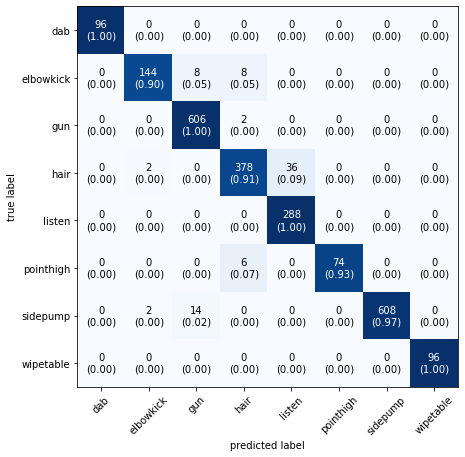

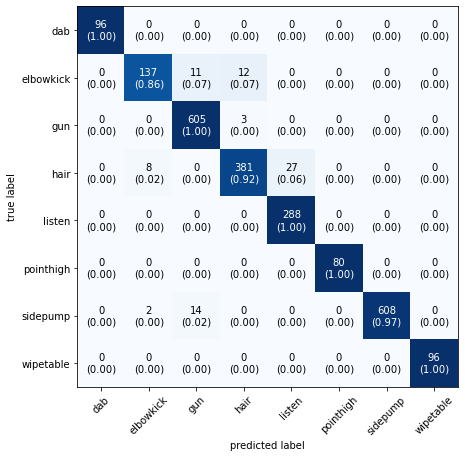

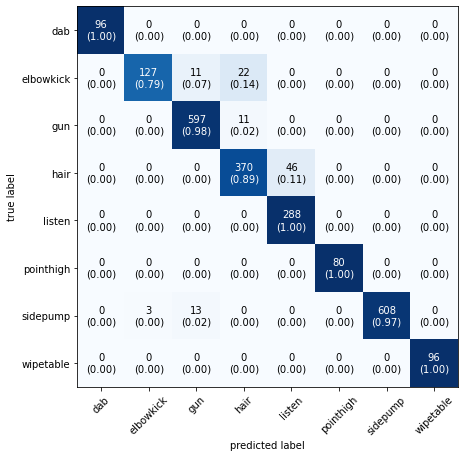

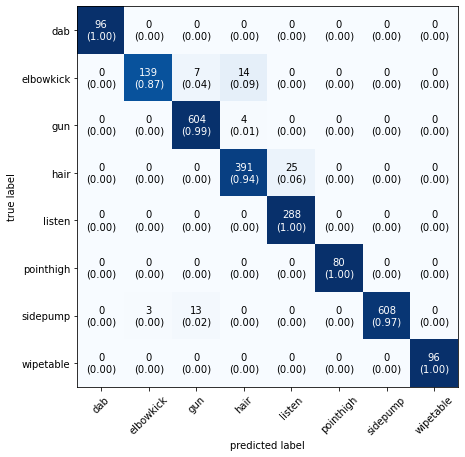

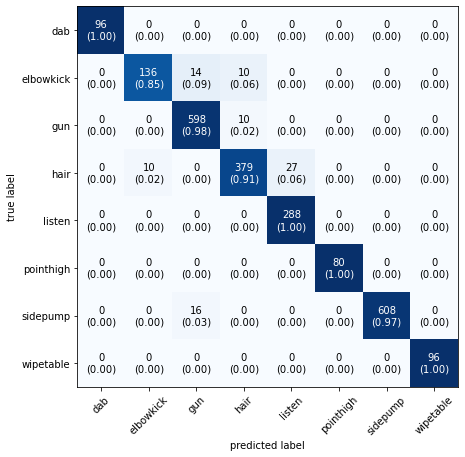

In [26]:
for i in range(5):
    plot_confusion_matrix(conf_mat=cm_hist[i], class_names=encoder.classes_, show_normed=True, 
                          figsize=(7,7), hide_spines=False)

### Classification Report

In [27]:
for i in range(5):
    print("\nClassification Report for fold {}:" .format(i+1))
    print(classification_report_hist[i])


Classification Report for fold 1:
              precision    recall  f1-score   support

         dab       1.00      1.00      1.00        96
   elbowkick       0.97      0.90      0.94       160
         gun       0.96      1.00      0.98       608
        hair       0.96      0.91      0.93       416
      listen       0.89      1.00      0.94       288
   pointhigh       1.00      0.93      0.96        80
    sidepump       1.00      0.97      0.99       624
   wipetable       1.00      1.00      1.00        96

    accuracy                           0.97      2368
   macro avg       0.97      0.96      0.97      2368
weighted avg       0.97      0.97      0.97      2368


Classification Report for fold 2:
              precision    recall  f1-score   support

         dab       1.00      1.00      1.00        96
   elbowkick       0.93      0.86      0.89       160
         gun       0.96      1.00      0.98       608
        hair       0.96      0.92      0.94       416
      li

### Training Histories

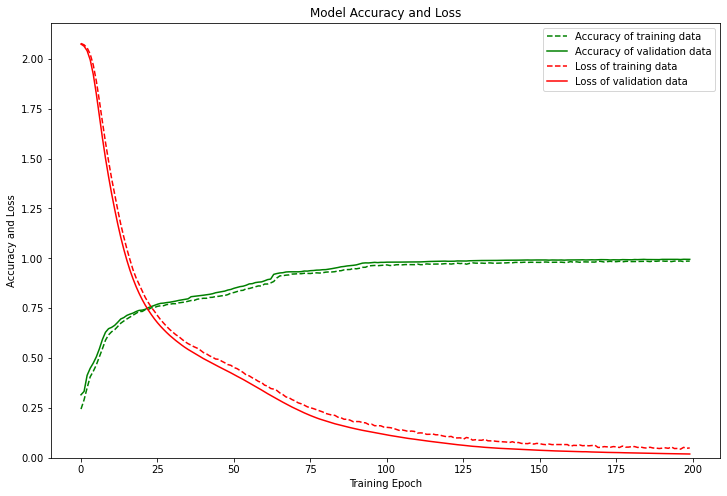

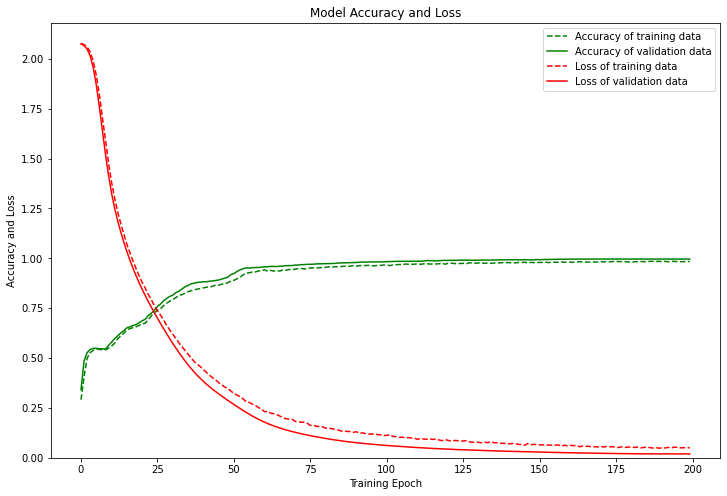

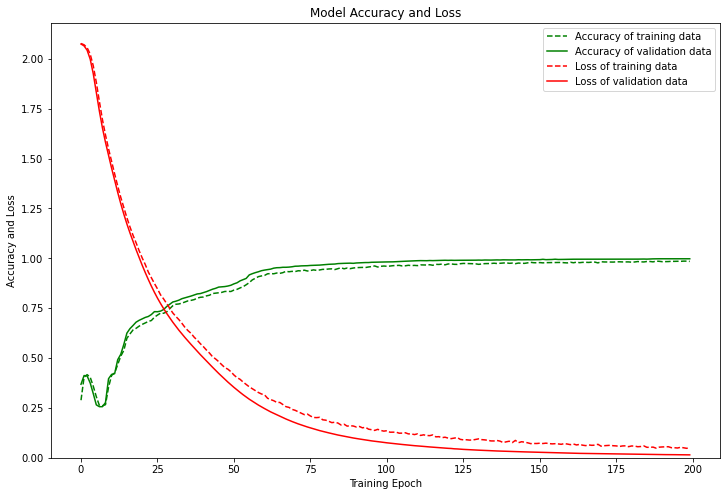

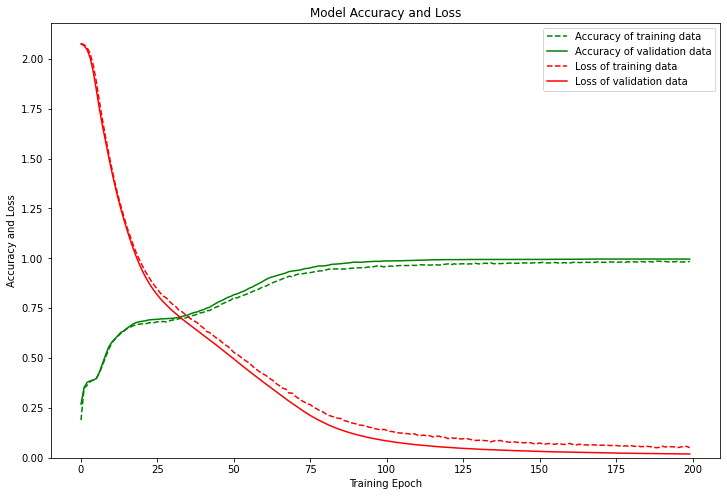

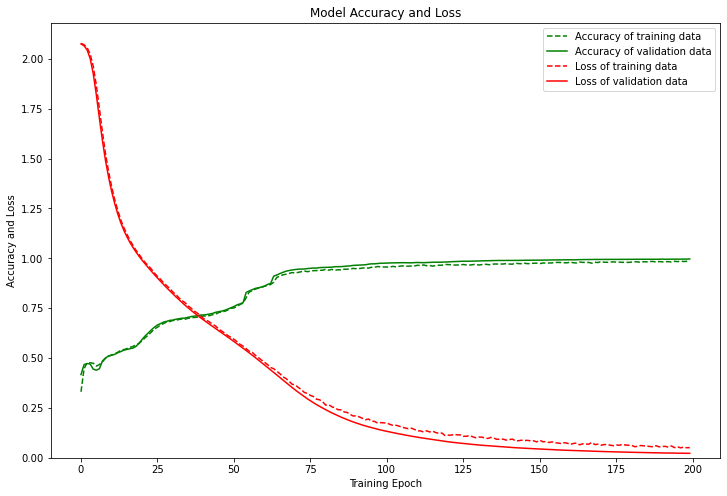

In [28]:
for history in train_histories:
    plt.figure(figsize=(12, 8))
    plt.plot(history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history['loss'], "r--", label="Loss of training data")
    plt.plot(history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()